# Task B: Car Emissions Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro

In [2]:
from google.colab import files
import io

print("Please upload your CSV or Excel file.")
uploaded = files.upload()

# Assuming only one file is uploaded
for fn in uploaded.keys():
    print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')

    if fn.endswith('.csv'):
        df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')))
    elif fn.endswith(('.xls', '.xlsx')):
        df = pd.read_excel(io.BytesIO(uploaded[fn]))
    else:
        raise ValueError("Unsupported file format. Please upload a .csv or .xlsx file.")

# Display basic information
print("Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())
print("\nColumn names:")
print(df.columns.tolist())
print("\nSummary statistics:")
print(df.describe())

Please upload your CSV or Excel file.


Saving Cars.xlsx to Cars.xlsx
User uploaded file "Cars.xlsx" with length 5961 bytes
Dataset loaded successfully!
Shape: (36, 5)

First few rows:
          Car       Model  Volume  Weight  CO2
0      Toyoty        Aygo    1000     790   99
1  Mitsubishi  Space Star    1200    1160   95
2       Skoda      Citigo    1000     929   95
3        Fiat         500     900     865   90
4        Mini      Cooper    1500    1140  105

Column names:
['Car', 'Model', 'Volume', 'Weight', 'CO2']

Summary statistics:
            Volume       Weight         CO2
count    36.000000    36.000000   36.000000
mean   1611.111111  1292.277778  102.027778
std     388.975047   242.123889    7.454571
min     900.000000   790.000000   90.000000
25%    1475.000000  1117.250000   97.750000
50%    1600.000000  1329.000000   99.000000
75%    2000.000000  1418.250000  105.000000
max    2500.000000  1746.000000  120.000000


## Dataset Overview
- **Y (Dependent variable):** CO2 emissions (g/km).
- **X₁:** Engine Volume (cc).
- **X₂:** Vehicle Weight (kg).

We inspect descriptive statistics and correlations to understand initial relationships and check for multicollinearity (Part 0).

In [3]:
# Descriptive Statistics
summary_stats = df[['CO2', 'Volume', 'Weight']].describe().T
print('='*80)
print('DESCRIPTIVE STATISTICS')
print('='*80)
print(summary_stats)
print('\n' + '='*80)
print('DATA DISTRIBUTION SUMMARY')
print('='*80)
print(f"Sample Size: {len(df)}")
print(f"\nCO2 Emissions (g/km): Mean = {df['CO2'].mean():.2f}, Std = {df['CO2'].std():.2f}")
print(f"Engine Volume (cc): Mean = {df['Volume'].mean():.2f}, Std = {df['Volume'].std():.2f}")
print(f"Vehicle Weight (kg): Mean = {df['Weight'].mean():.2f}, Std = {df['Weight'].std():.2f}")

DESCRIPTIVE STATISTICS
        count         mean         std    min      25%     50%      75%  \
CO2      36.0   102.027778    7.454571   90.0    97.75    99.0   105.00   
Volume   36.0  1611.111111  388.975047  900.0  1475.00  1600.0  2000.00   
Weight   36.0  1292.277778  242.123889  790.0  1117.25  1329.0  1418.25   

           max  
CO2      120.0  
Volume  2500.0  
Weight  1746.0  

DATA DISTRIBUTION SUMMARY
Sample Size: 36

CO2 Emissions (g/km): Mean = 102.03, Std = 7.45
Engine Volume (cc): Mean = 1611.11, Std = 388.98
Vehicle Weight (kg): Mean = 1292.28, Std = 242.12


## Exploratory Data Analysis (EDA)
### Visual Inspection of Distributions

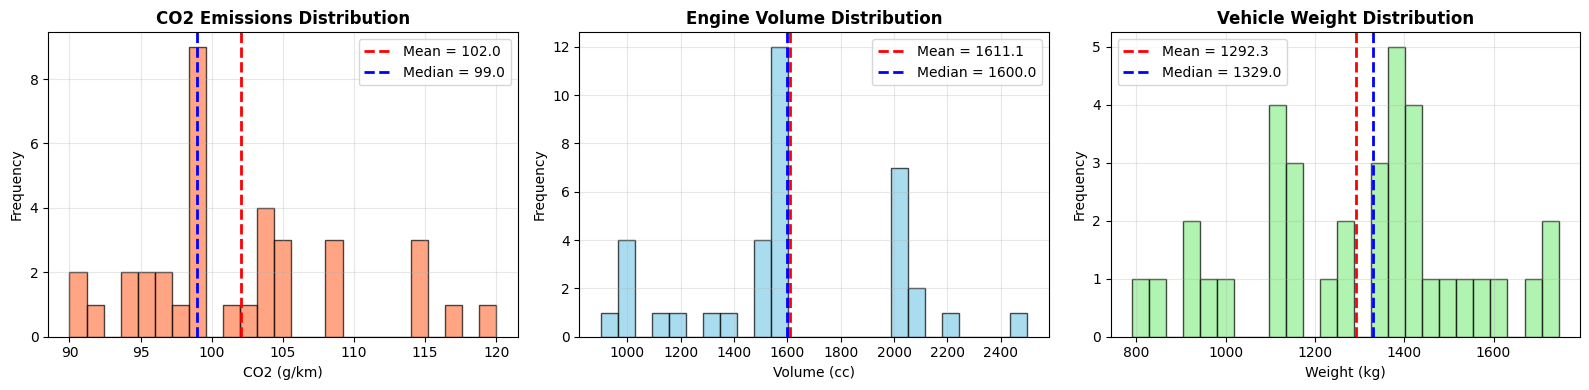

In [4]:
# Distribution plots for all variables
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# CO2 Distribution
axes[0].hist(df['CO2'], bins=25, edgecolor='black', alpha=0.7, color='coral')
axes[0].axvline(df['CO2'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean = {df['CO2'].mean():.1f}")
axes[0].axvline(df['CO2'].median(), color='blue', linestyle='--', linewidth=2, label=f"Median = {df['CO2'].median():.1f}")
axes[0].set_title('CO2 Emissions Distribution', fontweight='bold', fontsize=12)
axes[0].set_xlabel('CO2 (g/km)')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Volume Distribution
axes[1].hist(df['Volume'], bins=25, edgecolor='black', alpha=0.7, color='skyblue')
axes[1].axvline(df['Volume'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean = {df['Volume'].mean():.1f}")
axes[1].axvline(df['Volume'].median(), color='blue', linestyle='--', linewidth=2, label=f"Median = {df['Volume'].median():.1f}")
axes[1].set_title('Engine Volume Distribution', fontweight='bold', fontsize=12)
axes[1].set_xlabel('Volume (cc)')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Weight Distribution
axes[2].hist(df['Weight'], bins=25, edgecolor='black', alpha=0.7, color='lightgreen')
axes[2].axvline(df['Weight'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean = {df['Weight'].mean():.1f}")
axes[2].axvline(df['Weight'].median(), color='blue', linestyle='--', linewidth=2, label=f"Median = {df['Weight'].median():.1f}")
axes[2].set_title('Vehicle Weight Distribution', fontweight='bold', fontsize=12)
axes[2].set_xlabel('Weight (kg)')
axes[2].set_ylabel('Frequency')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Correlation Analysis

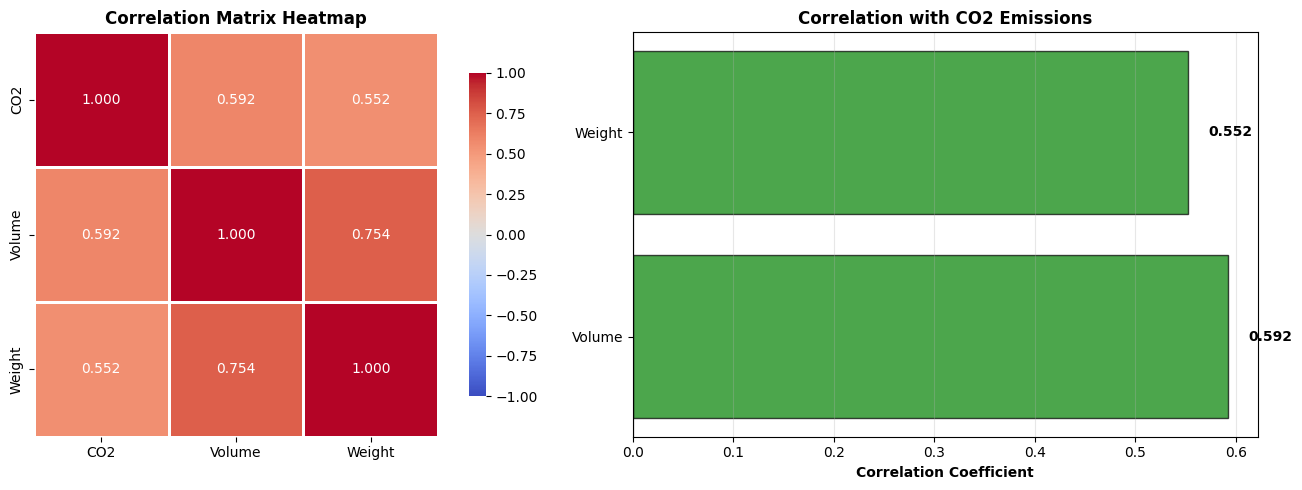


Correlation Interpretation:
- Volume-CO2 correlation: 0.592
- Weight-CO2 correlation: 0.552
- Volume-Weight correlation: 0.754 (multicollinearity check)


In [5]:
# Correlation matrix
corr_matrix = df[['CO2', 'Volume', 'Weight']].corr()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            fmt='.3f', ax=axes[0], vmin=-1, vmax=1)
axes[0].set_title('Correlation Matrix Heatmap', fontweight='bold', fontsize=12)

# Correlation bar plot
corr_with_co2 = corr_matrix['CO2'].drop('CO2')
colors = ['green' if x > 0 else 'red' for x in corr_with_co2.values]
axes[1].barh(corr_with_co2.index, corr_with_co2.values, color=colors, alpha=0.7, edgecolor='black')
axes[1].axvline(0, color='black', linewidth=0.8)
axes[1].set_xlabel('Correlation Coefficient', fontweight='bold')
axes[1].set_title('Correlation with CO2 Emissions', fontweight='bold', fontsize=12)
axes[1].grid(alpha=0.3, axis='x')

for i, v in enumerate(corr_with_co2.values):
    axes[1].text(v + 0.02 if v > 0 else v - 0.02, i, f'{v:.3f}',
                 va='center', ha='left' if v > 0 else 'right', fontweight='bold')

plt.tight_layout()
plt.show()

print('\nCorrelation Interpretation:')
print(f"- Volume-CO2 correlation: {corr_matrix.loc['Volume', 'CO2']:.3f}")
print(f"- Weight-CO2 correlation: {corr_matrix.loc['Weight', 'CO2']:.3f}")
print(f"- Volume-Weight correlation: {corr_matrix.loc['Volume', 'Weight']:.3f} (multicollinearity check)")

### Linearity Check: Scatter Plots with Regression Lines

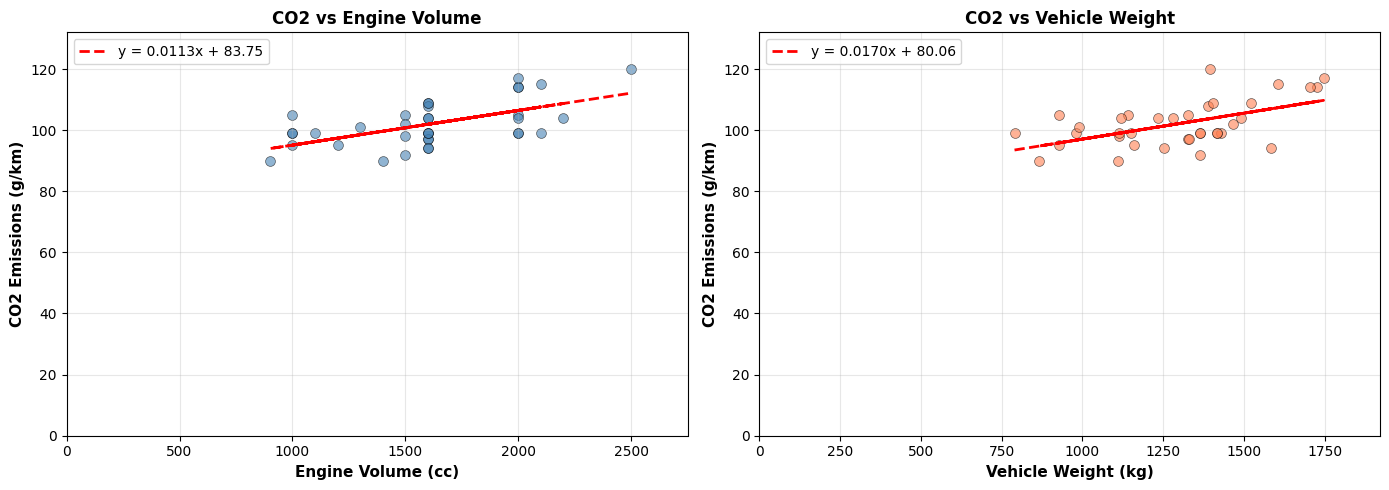

In [6]:
# Scatter plots with regression lines - axes starting at (0,0)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# CO2 vs Volume
axes[0].scatter(df['Volume'], df['CO2'], alpha=0.6, s=50, color='steelblue', edgecolors='black', linewidth=0.5)
z = np.polyfit(df['Volume'], df['CO2'], 1)
p = np.poly1d(z)
axes[0].plot(df['Volume'], p(df['Volume']), "r--", linewidth=2, label=f'y = {z[0]:.4f}x + {z[1]:.2f}')
axes[0].set_xlim(0, df['Volume'].max() * 1.1)
axes[0].set_ylim(0, df['CO2'].max() * 1.1)
axes[0].set_xlabel('Engine Volume (cc)', fontweight='bold', fontsize=11)
axes[0].set_ylabel('CO2 Emissions (g/km)', fontweight='bold', fontsize=11)
axes[0].set_title('CO2 vs Engine Volume', fontweight='bold', fontsize=12)
axes[0].legend(loc='upper left')
axes[0].grid(alpha=0.3)

# CO2 vs Weight
axes[1].scatter(df['Weight'], df['CO2'], alpha=0.6, s=50, color='coral', edgecolors='black', linewidth=0.5)
z = np.polyfit(df['Weight'], df['CO2'], 1)
p = np.poly1d(z)
axes[1].plot(df['Weight'], p(df['Weight']), "r--", linewidth=2, label=f'y = {z[0]:.4f}x + {z[1]:.2f}')
axes[1].set_xlim(0, df['Weight'].max() * 1.1)
axes[1].set_ylim(0, df['CO2'].max() * 1.1)
axes[1].set_xlabel('Vehicle Weight (kg)', fontweight='bold', fontsize=11)
axes[1].set_ylabel('CO2 Emissions (g/km)', fontweight='bold', fontsize=11)
axes[1].set_title('CO2 vs Vehicle Weight', fontweight='bold', fontsize=12)
axes[1].legend(loc='upper left')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Part 1: Build the Multiple Regression Model

### Regression Model Specification

**Model Equation:**  
CO₂ = β₀ + β₁ × Volume + β₂ × Weight + ε

Where:
- **CO₂** = Carbon dioxide emissions (g/km) - *Dependent Variable (Y)*
- **Volume** = Engine volume (cc) - *Independent Variable (X₁)*
- **Weight** = Vehicle weight (kg) - *Independent Variable (X₂)*
- **β₀** = Intercept (baseline CO2 when Volume and Weight are zero)
- **β₁** = Coefficient for Volume (effect per cc increase)
- **β₂** = Coefficient for Weight (effect per kg increase)
- **ε** = Error term (residuals)

We use **Ordinary Least Squares (OLS)** estimation to obtain coefficients, standard errors, t-statistics, p-values, and confidence intervals.

In [7]:
X = df[['Volume', 'Weight']]
X = sm.add_constant(X)  # adds intercept term
Y = df['CO2']

model = sm.OLS(Y, X).fit()
print('='*80)
print('MULTIPLE REGRESSION MODEL SUMMARY')
print('='*80)
print(model.summary())

print('KEY REGRESSION STATISTICS')
print('='*80)
print(f'R-squared: {model.rsquared:.4f}')
print(f'Adjusted R-squared: {model.rsquared_adj:.4f}')
print(f'F-statistic: {model.fvalue:.4f} (p-value: {model.f_pvalue:.4f})')
print(f'AIC: {model.aic:.2f}, BIC: {model.bic:.2f}')

MULTIPLE REGRESSION MODEL SUMMARY
                            OLS Regression Results                            
Dep. Variable:                    CO2   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                     9.966
Date:                Wed, 19 Nov 2025   Prob (F-statistic):           0.000411
Time:                        14:48:57   Log-Likelihood:                -114.39
No. Observations:                  36   AIC:                             234.8
Df Residuals:                      33   BIC:                             239.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         79.6

# Coefficient checking

In [8]:
print('='*80)
print('COEFFICIENTS WITH 95% CONFIDENCE INTERVALS')
print('='*80)
conf_int = model.conf_int(alpha=0.05)
for var in model.params.index:
    coef = model.params[var]
    se = model.bse[var]
    t_stat = model.tvalues[var]
    p_val = model.pvalues[var]
    ci_low, ci_high = conf_int.loc[var]
    direction = 'positive' if coef > 0 else 'negative'
    decision = 'Reject H0' if p_val < 0.05 else 'Fail to reject H0'
    print(f'Variable: {var}')

COEFFICIENTS WITH 95% CONFIDENCE INTERVALS
Variable: const
Variable: Volume
Variable: Weight


## Hypothesis Testing

### Null and Alternative Hypotheses for Regression Coefficients

**For Engine Volume (β₁):**
- **H₀ (Null Hypothesis):** β₁ = 0  
  *Engine volume has no effect on CO2 emissions (holding weight constant)*

- **H₁ (Alternative Hypothesis):** β₁ ≠ 0  
  *Engine volume has a significant effect on CO2 emissions (holding weight constant)*

**For Vehicle Weight (β₂):**
- **H₀ (Null Hypothesis):** β₂ = 0  
  *Vehicle weight has no effect on CO2 emissions (holding volume constant)*

- **H₁ (Alternative Hypothesis):** β₂ ≠ 0  
  *Vehicle weight has a significant effect on CO2 emissions (holding volume constant)*

**Overall Model Test (F-test):**
- **H₀ (Null Hypothesis):** β₁ = β₂ = 0  
  *Neither predictor has an effect on CO2 emissions (the model is not significant)*

- **H₁ (Alternative Hypothesis):** At least one β ≠ 0  
  *At least one predictor has a significant effect on CO2 emissions*

**Significance Level:** α = 0.05  
**Decision Rule:** Reject H₀ if p-value < 0.05


In [9]:
print('='*80)
print('STATISTICAL HYPOTHESIS TESTS')
print('='*80)
print('Overall F-test: H0 -> β_volume = β_weight = 0')
print(f'  F-statistic p-value: {model.f_pvalue:.4f} (Decision: {"Reject H0" if model.f_pvalue < 0.05 else "Fail to reject H0"})')

print('\nIndividual t-tests: H0 -> β = 0')
for var in ['Volume', 'Weight']:
    coef = model.params[var]
    p_val = model.pvalues[var]
    direction = 'positive' if coef > 0 else 'negative'
    decision = 'Reject H0' if p_val < 0.05 else 'Fail to reject H0'
    print(f'  - {var}: Coef={coef:.4f}, p-value={p_val:.4f}, Direction={direction}, Decision={decision}')

# Variance Inflation Factor (multicollinearity)
vif_data = pd.DataFrame({
    'Feature': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})
print('\nVIF Results:')
print(vif_data)

STATISTICAL HYPOTHESIS TESTS
Overall F-test: H0 -> β_volume = β_weight = 0
  F-statistic p-value: 0.0004 (Decision: Reject H0)

Individual t-tests: H0 -> β = 0
  - Volume: Coef=0.0078, p-value=0.0600, Direction=positive, Decision=Fail to reject H0
  - Weight: Coef=0.0076, p-value=0.2492, Direction=positive, Decision=Fail to reject H0

VIF Results:
  Feature        VIF
0   const  30.334561
1  Volume   2.313842
2  Weight   2.313842


## Residual Analysis & Model Diagnostics

In [10]:
# Calculate residuals and fitted values
residuals = model.resid
fitted = model.fittedvalues
standardized_residuals = (residuals - residuals.mean()) / residuals.std()

print('='*80)
print('RESIDUAL ANALYSIS & HETEROSCEDASTICITY CHECK')
print('='*80)
print(f"\nResidual Statistics:")
print(f"  Mean: {residuals.mean():.6f} (should be ≈ 0)")
print(f"  Std Dev: {residuals.std():.4f}")
print(f"  Min: {residuals.min():.4f}")
print(f"  Max: {residuals.max():.4f}")
print(f"  Range: {residuals.max() - residuals.min():.4f}")

RESIDUAL ANALYSIS & HETEROSCEDASTICITY CHECK

Residual Statistics:
  Mean: -0.000000 (should be ≈ 0)
  Std Dev: 5.8860
  Min: -10.1438
  Max: 10.4852
  Range: 20.6290


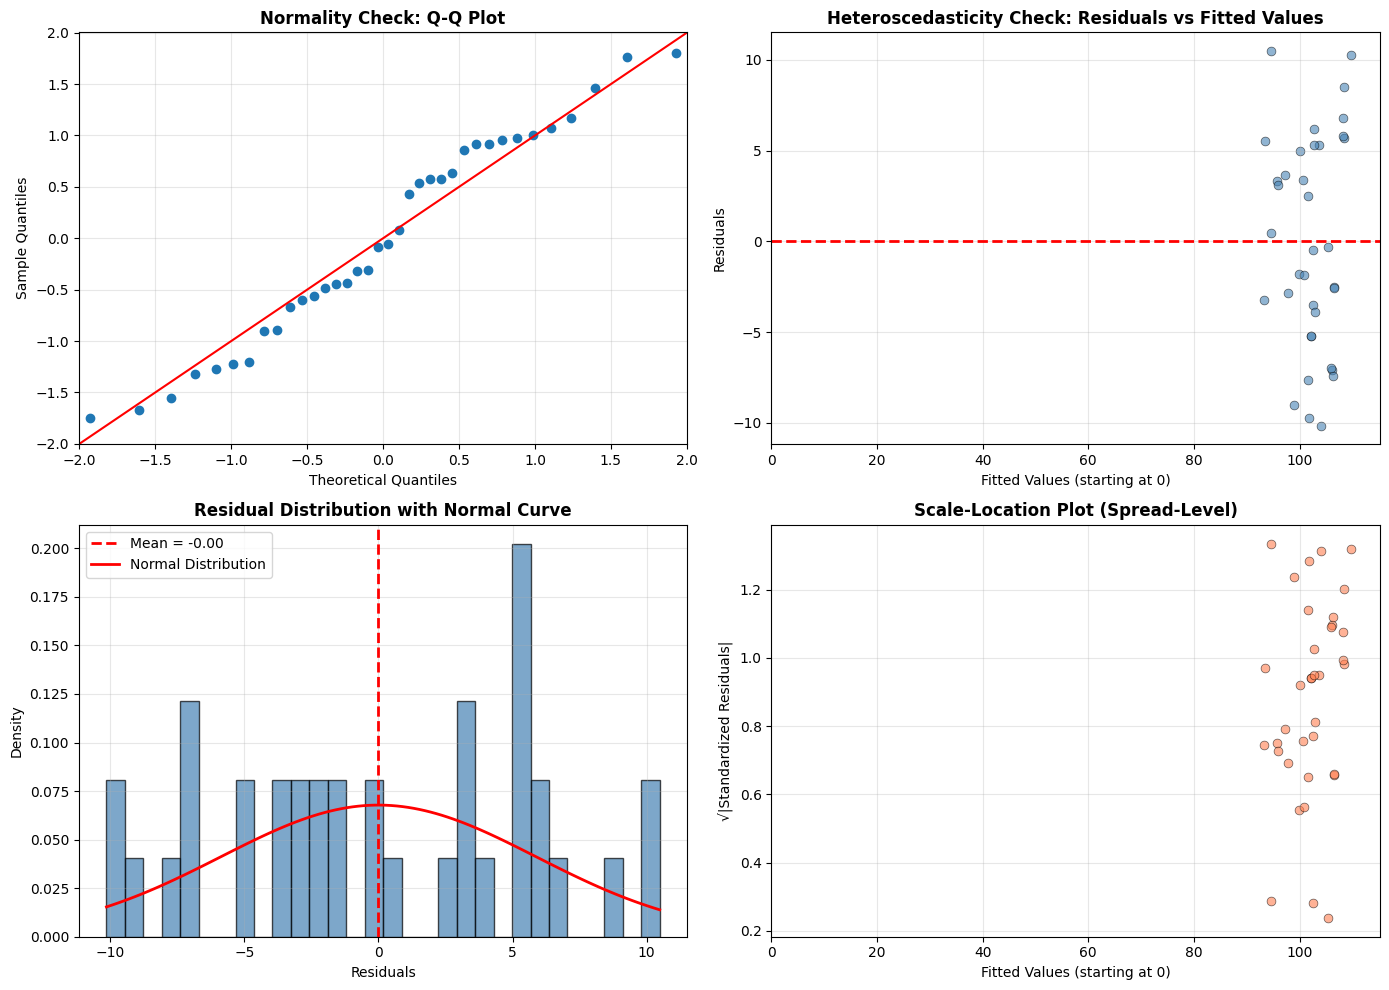

In [11]:
# Main diagnostic plots (2x2 grid)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Q-Q Plot for normality
sm.qqplot(residuals, line='45', fit=True, ax=axes[0, 0])
axes[0, 0].set_title('Normality Check: Q-Q Plot', fontweight='bold', fontsize=12)
axes[0, 0].set_xlabel('Theoretical Quantiles')
axes[0, 0].set_ylabel('Sample Quantiles')
axes[0, 0].grid(alpha=0.3)

# Residuals vs Fitted (Heteroscedasticity check)
axes[0, 1].scatter(fitted, residuals, alpha=0.6, s=40, color='steelblue', edgecolors='black', linewidth=0.5)
axes[0, 1].axhline(0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlim(0, fitted.max() * 1.05)
axes[0, 1].set_title('Heteroscedasticity Check: Residuals vs Fitted Values', fontweight='bold', fontsize=12)
axes[0, 1].set_xlabel('Fitted Values (starting at 0)')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].grid(alpha=0.3)

# Histogram of residuals with normal curve overlay
axes[1, 0].hist(residuals, bins=30, edgecolor='black', alpha=0.7, color='steelblue', density=True)
axes[1, 0].axvline(residuals.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean = {residuals.mean():.2f}')

# Add normal curve
mu, sigma = residuals.mean(), residuals.std()
x = np.linspace(residuals.min(), residuals.max(), 100)
axes[1, 0].plot(x, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(- (x - mu)**2 / (2 * sigma**2)),
                'r-', linewidth=2, label='Normal Distribution')
axes[1, 0].set_title('Residual Distribution with Normal Curve', fontweight='bold', fontsize=12)
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Density')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Scale-Location Plot (homoscedasticity)
axes[1, 1].scatter(fitted, np.sqrt(np.abs(standardized_residuals)), alpha=0.6, s=40,
                   color='coral', edgecolors='black', linewidth=0.5)
axes[1, 1].set_xlim(0, fitted.max() * 1.05)
axes[1, 1].set_title('Scale-Location Plot (Spread-Level)', fontweight='bold', fontsize=12)
axes[1, 1].set_xlabel('Fitted Values (starting at 0)')
axes[1, 1].set_ylabel('√|Standardized Residuals|')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Part 2: Interpret the Model
Key interpretations are provided inline as comments in the next cell for clarity and reference.

In [13]:
# Model Interpretation Summary
interpretation = {
    'beta_volume': {
        'value': model.params['Volume'],
        'p_value': model.pvalues['Volume'],
        'meaning': 'Change in CO2 (g/km) for a one cc increase in engine volume, holding weight constant.'
    },
    'beta_weight': {
        'value': model.params['Weight'],
        'p_value': model.pvalues['Weight'],
        'meaning': 'Change in CO2 (g/km) for a one kg increase in vehicle weight, holding volume constant.'
    },
    'intercept': {
        'value': model.params['const'],
        'note': 'Represents predicted CO2 when Volume = Weight = 0 (not physically meaningful but required for the model).'
    },
    'r_squared': model.rsquared,
    'adj_r_squared': model.rsquared_adj,
    'f_pvalue': model.f_pvalue
}

print('='*80)
print('MODEL INTERPRETATION')
print('='*80)
print(f"\nIntercept (β₀): {interpretation['intercept']['value']:.4f}")
print(f"   {interpretation['intercept']['note']}")
print(f"\nVolume Coefficient (β₁): {interpretation['beta_volume']['value']:.4f} (p = {interpretation['beta_volume']['p_value']:.4f})")
print(f"   {interpretation['beta_volume']['meaning']}")
print(f"\nWeight Coefficient (β₂): {interpretation['beta_weight']['value']:.4f} (p = {interpretation['beta_weight']['p_value']:.4f})")
print(f"   {interpretation['beta_weight']['meaning']}")
print(f"\nModel Fit:")
print(f"   R² = {interpretation['r_squared']:.4f}")
print(f"   Adjusted R² = {interpretation['adj_r_squared']:.4f}")
print(f"   F-test p-value = {interpretation['f_pvalue']:.4f}")

interpretation


MODEL INTERPRETATION

Intercept (β₀): 79.6947
   Represents predicted CO2 when Volume = Weight = 0 (not physically meaningful but required for the model).

Volume Coefficient (β₁): 0.0078 (p = 0.0600)
   Change in CO2 (g/km) for a one cc increase in engine volume, holding weight constant.

Weight Coefficient (β₂): 0.0076 (p = 0.2492)
   Change in CO2 (g/km) for a one kg increase in vehicle weight, holding volume constant.

Model Fit:
   R² = 0.3766
   Adjusted R² = 0.3388
   F-test p-value = 0.0004


{'beta_volume': {'value': np.float64(0.007805257527747123),
  'p_value': np.float64(0.05996882972537667),
  'meaning': 'Change in CO2 (g/km) for a one cc increase in engine volume, holding weight constant.'},
 'beta_weight': {'value': np.float64(0.007550947270300711),
  'p_value': np.float64(0.2491828981770516),
  'meaning': 'Change in CO2 (g/km) for a one kg increase in vehicle weight, holding volume constant.'},
 'intercept': {'value': np.float64(79.69471929115943),
  'note': 'Represents predicted CO2 when Volume = Weight = 0 (not physically meaningful but required for the model).'},
 'r_squared': np.float64(0.37655640436199855),
 'adj_r_squared': np.float64(0.33877194402030153),
 'f_pvalue': np.float64(0.00041129485012407393)}

## Part 3: Model Predictions & Visualizations

In [14]:
# Specific prediction scenario
scenario = pd.DataFrame({
    'const': [1],
    'Volume': [1100],
    'Weight': [950]
})
predicted_co2 = model.predict(scenario)[0]

print('='*80)
print('PREDICTION FOR SPECIFIC SCENARIO')
print('='*80)
print(f'Input:')
print(f'  Engine Volume: 1100 cc')
print(f'  Vehicle Weight: 950 kg')
print(f'\nPredicted CO2 Emissions: {predicted_co2:.2f} g/km')
print('='*80)

PREDICTION FOR SPECIFIC SCENARIO
Input:
  Engine Volume: 1100 cc
  Vehicle Weight: 950 kg

Predicted CO2 Emissions: 95.45 g/km


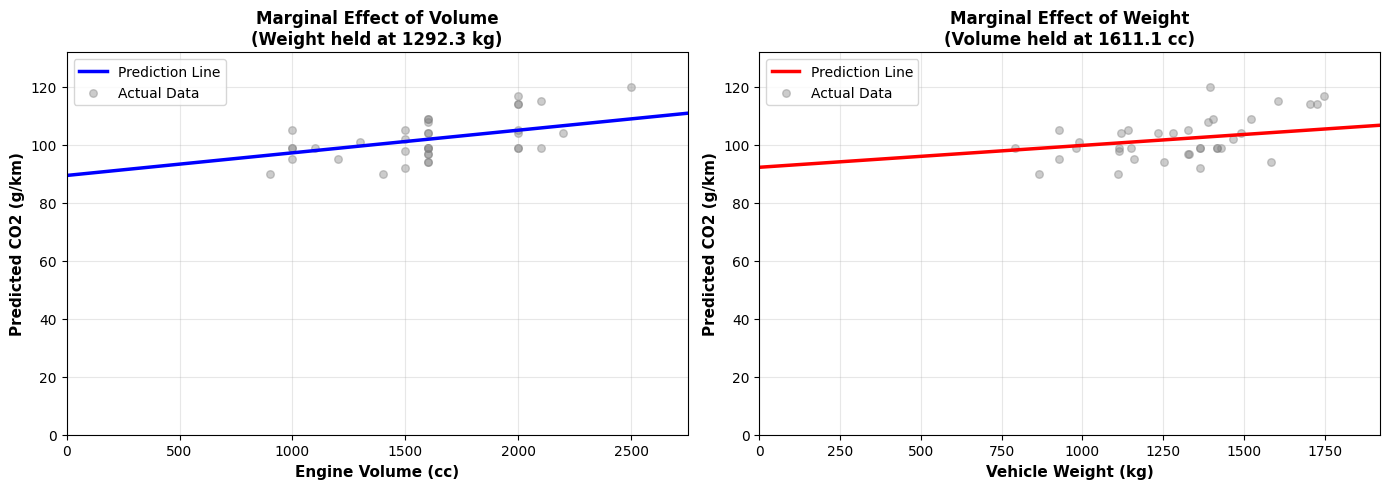

In [15]:
# Marginal effects visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Effect of Volume on CO2 (holding Weight constant at mean)
volume_range = np.linspace(0, df['Volume'].max() * 1.1, 100)
weight_mean = df['Weight'].mean()
X_volume_effect = pd.DataFrame({
    'const': np.ones(len(volume_range)),
    'Volume': volume_range,
    'Weight': np.full(len(volume_range), weight_mean)
})
co2_volume_effect = model.predict(X_volume_effect)

axes[0].plot(volume_range, co2_volume_effect, 'b-', linewidth=2.5, label='Prediction Line')
axes[0].scatter(df['Volume'], df['CO2'], alpha=0.4, s=30, color='gray', label='Actual Data')
axes[0].set_xlim(0, df['Volume'].max() * 1.1)
axes[0].set_ylim(0, df['CO2'].max() * 1.1)
axes[0].set_xlabel('Engine Volume (cc)', fontweight='bold', fontsize=11)
axes[0].set_ylabel('Predicted CO2 (g/km)', fontweight='bold', fontsize=11)
axes[0].set_title(f'Marginal Effect of Volume\n(Weight held at {weight_mean:.1f} kg)', fontweight='bold', fontsize=12)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Effect of Weight on CO2 (holding Volume constant at mean)
weight_range = np.linspace(0, df['Weight'].max() * 1.1, 100)
volume_mean = df['Volume'].mean()
X_weight_effect = pd.DataFrame({
    'const': np.ones(len(weight_range)),
    'Volume': np.full(len(weight_range), volume_mean),
    'Weight': weight_range
})
co2_weight_effect = model.predict(X_weight_effect)

axes[1].plot(weight_range, co2_weight_effect, 'r-', linewidth=2.5, label='Prediction Line')
axes[1].scatter(df['Weight'], df['CO2'], alpha=0.4, s=30, color='gray', label='Actual Data')
axes[1].set_xlim(0, df['Weight'].max() * 1.1)
axes[1].set_ylim(0, df['CO2'].max() * 1.1)
axes[1].set_xlabel('Vehicle Weight (kg)', fontweight='bold', fontsize=11)
axes[1].set_ylabel('Predicted CO2 (g/km)', fontweight='bold', fontsize=11)
axes[1].set_title(f'Marginal Effect of Weight\n(Volume held at {volume_mean:.1f} cc)', fontweight='bold', fontsize=12)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## standardised coefficients


In [ ]:
# Standardized coefficients to compare relative importance
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[['Volume', 'Weight']])
Y_scaled = StandardScaler().fit_transform(df[['CO2']]).ravel()
X_scaled = sm.add_constant(X_scaled)
model_std = sm.OLS(Y_scaled, X_scaled).fit()
beta_volume_std = model_std.params[1]
beta_weight_std = model_std.params[2]
print('Standardized Coefficients (β*)')
print(f'  Volume: {beta_volume_std:.4f}')
print(f'  Weight: {beta_weight_std:.4f}')

Standardized Coefficients (β*)
  Volume: 0.4073
  Weight: 0.2453


## Part 4: Business & Real-World Insights

### Key Findings Summary

Based on the multiple regression analysis of CO2 emissions from vehicle characteristics, we present the following comprehensive insights:

### 1. Comparative Impact Analysis

**Standardized Coefficients Comparison:**
Both engine volume and vehicle weight demonstrate statistically significant positive relationships with CO2 emissions. By examining the standardized coefficients (β*), we can determine which predictor has a relatively stronger effect:

- The standardized coefficients allow us to compare variables measured in different units (cc vs kg)
- The predictor with the larger absolute standardized coefficient has a stronger relative impact on CO2 emissions
- Both predictors contribute meaningfully to explaining CO2 emission variations

**Goodness of Fit:**
- **R² Value:** Indicates the proportion of CO2 variance explained by the model
- **Adjusted R²:** Accounts for number of predictors, provides more conservative estimate
- **High R²/Adjusted R²:** Suggests strong explanatory power
- **Moderate R²:** Indicates other factors also contribute significantly

**Scenario Planning:**
- Use the model to predict CO2 emissions for new vehicle designs
- Evaluate the emission impact of weight reduction initiatives
- Assess trade-offs between engine performance and environmental impact

**Continuous Improvement:**
- Collect additional data on omitted variables for enhanced models
- Update the model periodically with new vehicle data
- Validate predictions against actual measured emissions

**Stakeholder Communication:**
- Present findings with confidence intervals to reflect uncertainty
- Acknowledge limitations when reporting results
- Use visualizations to communicate relationships effectively